#### LangChain
LangChain is a framework that essentially makes development with large language models easier for you. It allows you to tie together various elements that you might need for an LLM-based application (vector databases, models, prompts, etc.). In a modular manner, making it much easier on you to connect everything together with very few lines of code. 

In [1]:
!pip install langchain --upgrade --quiet

#### LangChain Community
LangChain has split up its many components into several sub-libraries, so you may have to do a little bit of digging through the [API documentation](https://api.python.langchain.com/en/latest/langchain_api_reference.html) to find what you are looking for. A lot of what you'll be looking for can be found in [LangChain Community](https://api.python.langchain.com/en/latest/community_api_reference.html), which is the sub-library that handles things like third-party integrations. Some integrations include those of OpenAI, HuggingFace, VLLM, etc.

In [2]:

import langchain_community

from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain_community.llms.openai import OpenAI

#### Retrieval-Augmented Generation (RAG)
In this demonstration, I will be introducing you to langchain by guiding you through the creation of a simplified RAG-based application. For those who aren't familiar with the topic, RAG stands for Retrieval-Augmented Generation. Like the phrase suggests, RAG is a method in which you RETRIEVE external information to AUGMENT your model to GENERATE in a certain way.

Here's an example to make things a little more concrete:

Imagine that you are trying to build an application with a large language model (GPT, LLaMA, Mistral, whichever you prefer) that has been pre-trained on data up to 2023. If you ask the model about the total solar eclipse that occurred on 8 Apr 2024, you couldn't possibly get an accurate answer, since the model is not psychic and cannot peer into the future. 

One option to fix the situation would be to train the model on current data. While this is an option, it isn't very viable, and is hardly worth the effort. The reality is that pre-training a model requires resources that most people don't have, and trying to repeatedly train a model to keep it up to date is probably not the best way to make use of your resources.

Another approach you might take is connecting the model to an outside source of information, such as a website. You toss a query to the website, the website somehow finds resources that seem relevant to your query, and the LLM references those resources to create a response. This way, you don't have to worry about whether the model itself has been trained on that information; you're going to provide it with what it needs explicitly. This is an example of RAG.

For now, we'll try implementing the example above using LangChain.

First, we need a source of information that we can retrieve data from. While LangChain provides support for many different forms of data, we will begin with data from ArXiv.

In [3]:
%pip install --upgrade --quiet  arxiv pymupdf

Note: you may need to restart the kernel to use updated packages.


In [4]:
from langchain_community.document_loaders import ArxivLoader

attention_doc = ArxivLoader(query = '1706.03762', load_max_docs = 1).load()
print(attention_doc[0].metadata)

{'Published': '2023-08-02', 'Title': 'Attention Is All You Need', 'Authors': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin', 'Summary': 'The dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks in an encoder-decoder configuration. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer, based\nsolely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to be\nsuperior in quality while being more parallelizable and requiring significantly\nless time to train. Our model achieves 28.4 BLEU on the WMT 2014\nEnglish-to-German translation task, improving over the existing best results,\nincluding ensembles by over 2 BLEU. On the WMT 2014 English-to-French\ntranslation task, our

Before we delve into how the data above will be used, it may be helpful to discuss the structure of a LangChain `Document` since this is the form that LangChain loaders load data with. In the above code, the ArXiv loader loads a list of LangChain documents, where each `Document` contains the contents of a query result. Because we have set the `load_max_docs` parameter to 1, `attention_doc` will only contain a single LangChain Document, corresponding to a single query result.

In [5]:
print("ArXiv Loader return type : ", type(attention_doc))
print("Length of return type : ", len(attention_doc))
print("Type of each element : ", type(attention_doc[0]))

ArXiv Loader return type :  <class 'list'>
Length of return type :  1
Type of each element :  <class 'langchain_core.documents.base.Document'>


A LangChain `Document` is comprised of two components: `page_content` and `metadata`. Think of `page_content` as the actual text that the data originally holds. On the other hand, the `metadata` may contain all sorts of information, depending on what is available. Since the document above has been loaded from ArXiv, its `metadata` includes the paper's publication date, its title, authors, and a summary.

In [6]:
attention_doc = attention_doc[0]
print("Page Content : ", attention_doc.page_content[:100], '...\n')
print("Metadata : ")
for key in attention_doc.metadata.keys():
    print(f"'{key}' : '{attention_doc.metadata[key]}'")

Page Content :  Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and ...

Metadata : 
'Published' : '2023-08-02'
'Title' : 'Attention Is All You Need'
'Authors' : 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin'
'Summary' : 'The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to be
superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014
English-to-German translation task, improving

Now that we have a basic understanding on the type of data we will be handling, we can proceed with setting up a retrieval system for our language model. Sure, we have a source of information, but this isn't enough. Given a question from a user, we want to provide our language model with enough context to come up with an answer. Tossing the whole document in for context is hardly a solution; the length of the inputs to a language model can have drastic impacts on its generation speed and quality. 

In other words, we want to accurately extract the parts of the text that are relevant to a given query, and provide those to the language model instead.

To do this, we first split the contents of the document into multiple sub-texts, which we will call chunks. To do this, we use the text splitters provided by LangChain 

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50,
    length_function = len,
    separators = ['\n\n', '\n', ' ']
)

The following explanations (as well as many from this point on) were written to help newcomers gain an intution on how RAG works as a whole; many details, while they are important, may be omitted for sake of coherence. 

The `chunk_size` determines an upper bound for the length of each chunk. Again, we don't want to shove too much text into our language models for a variety of reasons.

The `chunk_overlap` parameter determines how much overlapping text there should be between each chunk. Because we are splitting our original text into sub-texts based purely on length (and not, for example, by sections or chapters), there may be instances in which texts that belong together are split apart; the chunk_overlap parameter helps mitigate this by acting as a sort of buffer.

An interesting thing about the `RecursiveCharacterTextSplitter` is that it takes into consideration the `chunk_size` and `separators` to look for what seem like appropriate splitting points in the original text. For those interested the details of its workings, [DEV Community](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) has a pretty straightforward explanation about it.

In [8]:
split_docs = text_splitter.split_documents([attention_doc])

# Show the first five examples
for split_doc in split_docs[:5]:
    print(split_doc)

page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu' metadata={'Published': '2023-08-02', 'Title': 'Attention Is All You Need', 'Authors': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin', 'Summary': 'The dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks in an encoder-decoder configuration. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propo

With the above segment of code, we can see that the original text has been successfully split into multiple chunks. One thing to note is that the `split_documents` function doesn't quite just take text and split it; we have the `split_text` function for that. Instead, the `split_documents` function takes an `Iterable` of LangChain Documents and splits those Documents into multiple new documents. So the `page_content` of each of the new Documents contains a portion of the original text, but how are the `metadata` of the new Documents created?

In [9]:
metadatas = [split_doc.metadata for split_doc in split_docs]

# Show the first five examples
for metadata in metadatas[:5]:
    print(metadata)

{'Published': '2023-08-02', 'Title': 'Attention Is All You Need', 'Authors': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin', 'Summary': 'The dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks in an encoder-decoder configuration. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer, based\nsolely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to be\nsuperior in quality while being more parallelizable and requiring significantly\nless time to train. Our model achieves 28.4 BLEU on the WMT 2014\nEnglish-to-German translation task, improving over the existing best results,\nincluding ensembles by over 2 BLEU. On the WMT 2014 English-to-French\ntranslation task, our

We can see that the `metadata` of the original LangChain Document has been copied over to each of its children. Under the hood, the `split_documents` function performs two main operations:

1. Split the `page_content` into multiple chunks and creates a new Document for each
2. Copy the original Document's `metadata` for all of the newly generated Documents

We now have data in the form that we want (chunks), but we still don't know how to determine which chunk corresponds to a particular query. We're going to be setting up a vector database to do that for us.

In [10]:
!pip install langchain-chroma --quiet

from langchain_chroma import Chroma


#### Vector Databases
For those familiar with relational databases, think of how one queries its contents with SQL. You look for rows of data that fit the criteria detailed by your query (`age > 8`, `country == Korea`). In essence, you are looking for exact matches. With vector databases, you are looking for *similar* matches instead. For that to make more sense, we must first understand embedding models.

In [11]:
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name = 'sentence-transformers/all-mpnet-base-v2',
    model_kwargs = {
        'device' : 'cpu',
    },
    encode_kwargs = {
        'normalize_embeddings' : True,
    }
)

In [12]:
embedding_model.embed_query('hello')[:5]

[0.030639825388789177,
 -0.00623022485524416,
 -0.0021215418819338083,
 0.013879154808819294,
 0.026486855000257492]

As AWS puts it, ["Embedding models are algorithms trained to encapsulate information into dense representations in multi-dimensional space."](https://aws.amazon.com/what-is/embeddings-in-machine-learning/?nc1=h_ls) If you aren't familiar with vectors and higher-dimensional spaces, think of embedding models as algorithms that convert text into coordinates in the x-y plane. Somehow, the embedding model knows that points representing words or phrases similar or relevant to each other ('dog' and 'cat') should be placed nearby and that those that aren't should be spaced further apart ('giraffe' and 'tank'). [This image](https://miro.medium.com/v2/resize:fit:850/1*jptD3Rur8gUOftw-XHrezQ.png) from [this article](https://medium.com/@eugene-s/the-rise-of-embedding-technology-and-vector-databases-in-ai-4a8db58eb332) about embeddings might help if you're struggling to make sense of what that would look like.

So those decimals in that cell above are actually the coordinates for a vector (or point if you would prefer) in an incredibly high-dimensional space (I've only printed the first five as a demonstration). Keep that in mind, but don't worry about picturing it; an image of the 3-dimensional or 2-dimensional alternative works fine for gaining intuition.

What's nice about embedding models (and the vector embeddings that they create) is that they provide machines with a meaningful way to make comparisons. More specifically, it's obvious to us that the words 'child' and 'parent' have some sort of relationship, but a machine doesn't know that. If you give it two vector embeddings, however, a machine can tell you things like how far apart the two are and THAT can be used as concrete indicator of things like 'relevance' or 'similarity' - the smaller the distance between them, the closer the two vectors are, and the more likely they are to be relevant with one another.

In [13]:
# Create a vector database (Chroma) using the ArXiv documents and embedding model from above
chromadb = Chroma.from_documents(
    documents = split_docs,
    embedding = embedding_model
)

Vector databases work by representing the data contained within with vector embeddings. Think of them as a huge collection of `keys` and `values`. When data is added to a vector database, the data (corresponding to the `values`) is first converted into a vector embedding (`keys`) as you've seen above. These vector embeddings act as the 'key' that represent the data that has been added. So instead of looking for exact matches like a relational database, vector databases work by figuring out which entries seem most similar or relevant to the query (their vector embeddings are closest to the query).

It does this effectively with Approximate Nearest Neighbor (ANN) algorithms like HNSW. The details of such algorithms are beyond the scope of this particular tutorial, but I have linked a few useful guides/tutorials in the Resources folder if you're interested.

The search process, summarized, can be thought of as follows:
1. Query is provided by user
2. Query is converted into a vector embedding
3. The vector database somehow identifies the `keys` (vectors) that are closest to the query vector embedding
4. The vector database returns the `values` associated with those `keys`

In [14]:
retrieved_document = chromadb.similarity_search('how is attention implemented in a transformers model?', k = 1)
print(retrieved_document[0].page_content)
print(retrieved_document[0].metadata)

3.2.3
Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
• In "encoder-decoder attention" layers, the queries come from the previous decoder layer,
and the memory keys and values come from the output of the encoder. This allows every
position in the decoder to attend over all positions in the input sequence. This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence models such as
[38, 2, 9].
{'Authors': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin', 'Published': '2023-08-02', 'Summary': 'The dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks in an encoder-decoder configuration. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer, based\nsolely on attention mechanisms, disp

A simple search seems to yield decent results; at the very least, the document returned by the vector database doesn't seem completely unrelated to the query we've provided. As a side note, the `similarity_search` function returns a list of LangChain Documents, which is why we need to perform indexing as we've done above. The size of the list is determined by the `k` paramter we've set at 1. 

So far we've done the following:
1. Select the data to use for querying
    - Attention is All You Need paper
2. Prepared the data in a way that our language model can use
    - Split text into chunks
3. Prepared a way to select which of the data to hand over to the language model
    - The vector database does this for us using an embedding model

So now all that's left is to hand this information over to a language model that can use it. 

In [15]:
#!pip install --quiet huggingface_hub==0.23.0 transformers

In [16]:
from huggingface_hub import login
login()

In [17]:
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
hf = HuggingFacePipeline.from_model_id(
    model_id="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 200},
    device_map = 'cuda'
)

c:\Users\cwpar\anaconda3\envs\wheel_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
hf("Continue the fibonacci sequence, with 100 as an upper bound: 1, 1, 2, 3, 5, ")

c:\Users\cwpar\anaconda3\envs\wheel_env\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'Continue the fibonacci sequence, with 100 as an upper bound: 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75059, 121355, 196418, 317811, 514229, 832040, 1346264, 2178301, 3524578, 5702887, 9227465, 14930352'

The code in the cell above may not make much sense to those unfamilar with the HuggingFace libraries, but the details for that are beyond the scope of this introductory tutorial. For now, all that's important is that the `pipeline` that has been constructed above allows you to toss text into a language model and receive text back.

Two things you can notice from the output of the cell above is that the language model we've chosen takes a substantial amount of time for generation, and that it does not seem to be listening to our directions. If you're used to using ChatGPT, the difference in generation quality may seem stark; ChatGPT does do a better job adhering to the instructions we've provided.

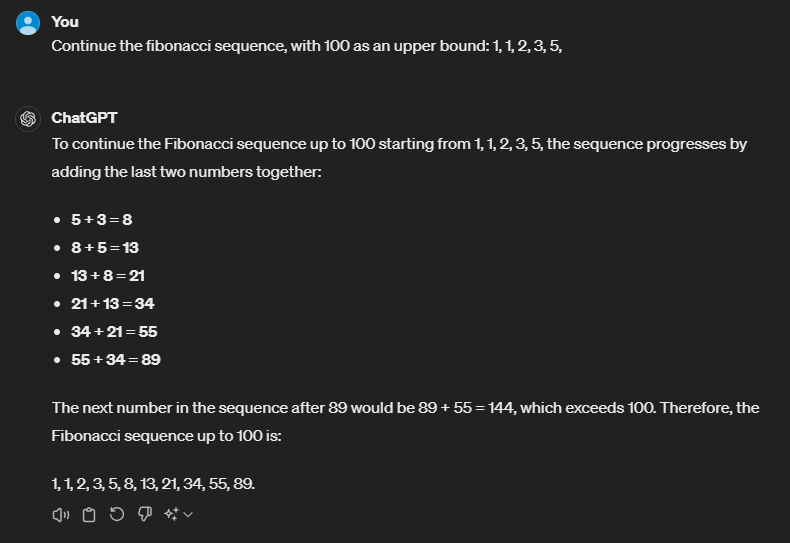

But keep in mind that the GPT models are models on a completely different scale altogether. The GPT-3 model contained 175B parameters, and the newest GPT-4 model is rumored to have a parameter size exceeding 1T. The `TinyLlama` model we are using, on the other hand, only has ~1B parameters. As a rule of thumb, models with more parameters generally perform better than smaller ones. It shouldn't be too surprising to find that a 1B model can't compete with a 1T model.

If you have an OpenAI API account, feel free to substitute the above code with the code below.

In [19]:
# from langchain_community.llms.openai import OpenAI
# llm = OpenAI(
#     openai_api_key = "YOUR OPEN AI API KEY GOES HERE",
#     model = 'gpt-4-turbo'
# )

Now that we have a language model capable of generation, we want to provide it with some guidelines on *how* it will generate. This role is fulfilled by prompts, which can be thought of as instructions that may include details on how the model should treat its inputs and how it should format its outputs. Here's a sample to get started:

In [20]:
from langchain_core.prompts.prompt import PromptTemplate

template = """Instruction: 
Answer the following question using details from the context.

Question:
{question}

Context: 
{context}"""

prompt = PromptTemplate(
    input_variables = ['question', 'context'],
    template = template
)

Think of the prompt template initialized above as a fill-in-the-blanks sheet. There exists a template that should be maintained no matter the input, and variables that serve as fields that accept data. Now think back to the overall structure of the RAG system we want to implement: we want to have a language model that uses data retrieved from a vector database to answer a question. Broken down into steps, that would look something like:
1. Query the vector database
2. Retrieve relevant documents from the vector database
3. Provide the language model with those documents as context to generate an answer to the initial query

The prompt template above is designed to enable Step 3. All that's left is to connect all the pieces we've made.

In [21]:
def query(question : str):
    relevant_docs = chromadb.similarity_search(query = question, k = 1)
    context = relevant_docs[0].page_content
    print(f"> Context\n{context}\n")
    llm_prompt = prompt.format(question = question, context = context)
    print(f"> Prompt\n{llm_prompt}\n")
    return hf(llm_prompt)[len(llm_prompt):]

In [22]:
print("> LLM Result\n", query('How is the attention mechanism implemented in a transformer model?'))

> Context
3.2.3
Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
• In "encoder-decoder attention" layers, the queries come from the previous decoder layer,
and the memory keys and values come from the output of the encoder. This allows every
position in the decoder to attend over all positions in the input sequence. This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence models such as
[38, 2, 9].

> Prompt
Instruction: 
Answer the following question using details from the context.

Question:
How is the attention mechanism implemented in a transformer model?

Context: 
3.2.3
Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
• In "encoder-decoder attention" layers, the queries come from the previous decoder layer,
and the memory keys and values come from the output of the encoder. This allows every
position in the decoder to attend over all positi

With the above cell, we can see that our function is behaving as expected. The vector database we had initialized earlier is queried for a relevant document, and this document is used to guide the language model in its generation. The quality of the generation, however, seems questionable. The language model isn't answering from the text we have provided it with. With a GPT model, however, results are different.

In [23]:
from langchain_community.llms.openai import BaseOpenAI
import os

os.environ['OPENAI_API_KEY'] = "YOUR OPENAI API KEY GOES HERE"

openai_llm = BaseOpenAI()

In [37]:
def query(question : str):
    relevant_docs = chromadb.similarity_search(query = question, k = 1)
    context = relevant_docs[0].page_content
    llm_prompt = prompt.format(question = question, context = context)
    return openai_llm(prompt = llm_prompt, model = 'gpt-3.5-turbo-instruct')

In [38]:
print("> OpenAI Result\n", query('How is the attention mechanism implemented in a transformer model?'))

> OpenAI Result
 

The attention mechanism is implemented in a transformer model through multi-head attention, specifically in encoder-decoder attention layers. In this type of attention, the queries come from the previous decoder layer while the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence, mimicking the typical encoder-decoder attention mechanisms used in sequence-to-sequence models. 


Disregarding the quality of the generations themselves, that's all there is to a basic RAG pipeline. The code above can actually be simplified to very few lines with the following code:

In [49]:
from langchain.chains import LLMChain, RetrievalQA

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50,
    length_function = len,
    separators = ['\n\n', '\n', ' ']
)

vectorstore = Chroma.from_documents(
    documents = text_splitter.split_documents(ArxivLoader(query = '1706.03762', load_max_docs = 1).load()),
    embedding = HuggingFaceEmbeddings(
        model_name = 'sentence-transformers/all-mpnet-base-v2',
        model_kwargs = {
            'device' : 'cpu',
        },
        encode_kwargs = {
            'normalize_embeddings' : True,
        }
    )
)
retriever = vectorstore.as_retriever()

model = HuggingFacePipeline.from_model_id(
    model_id="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 200},
    device_map = 'cuda'
)

chain = RetrievalQA.from_llm(llm = model, retriever = retriever)

c:\Users\cwpar\anaconda3\envs\wheel_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [50]:
chain.run(query = 'How is the attention mechanism implemented in transformer models?')

'Use the following pieces of context to answer the question at the end. If you don\'t know the answer, just say that you don\'t know, don\'t try to make up an answer.\n\nContext:\n3.2.3\nApplications of Attention in our Model\nThe Transformer uses multi-head attention in three different ways:\n• In "encoder-decoder attention" layers, the queries come from the previous decoder layer,\nand the memory keys and values come from the output of the encoder. This allows every\nposition in the decoder to attend over all positions in the input sequence. This mimics the\ntypical encoder-decoder attention mechanisms in sequence-to-sequence models such as\n[38, 2, 9].\n\nContext:\n3.2.3\nApplications of Attention in our Model\nThe Transformer uses multi-head attention in three different ways:\n• In "encoder-decoder attention" layers, the queries come from the previous decoder layer,\nand the memory keys and values come from the output of the encoder. This allows every\nposition in the decoder to at